In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import PIL.Image as pil_image
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import glob
import cv2
import random
import h5py
from skimage.measure import compare_ssim as ssim
import math
from tqdm.notebook import tqdm

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/Final_Project/Images

/content/drive/My Drive/Final_Project/Images


In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1024)
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 16

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [0]:
path_91_x2_train_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91-image_x2.h5"
path_set5_x2_valid_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_image_x2_valid.h5"

path_91_x3_train_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91-image_x3.h5"
path_set5_x3_valid_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91_image_x3_valid.h5"

path_91_x4_train_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91-image_x4.h5"
path_set5_x4_valid_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91_image_x4_valid.h5"

In [0]:
class SubImagesSet(Dataset):
    """Subimages dataset."""

    def __init__(self, images_path, limit = None):
        images = h5py.File(images_path, 'r')
        self.true_images = np.array(images['hr'][:])
        self.deg_images = np.array(images['lr'][:])
        if limit:
          self.true_images = self.true_images[:limit]
          self.deg_images = self.deg_images[:limit]

    def __len__(self):
      return self.true_images.shape[0]
    
    def __getitem__(self, index):
      if torch.is_tensor(index):
            index = index.tolist()
      y = torch.tensor(self.true_images[index], dtype = torch.float, device = device)/255
      X = torch.tensor(self.deg_images[index], dtype = torch.float, device = device)/255
      return [torch.unsqueeze(X, dim = 2), torch.unsqueeze(y, dim = 2)]


In [0]:
train_dataset = SubImagesSet(path_91_x3_train_samples_h5, 21000)

In [0]:
valid_dataset = SubImagesSet(path_set5_x3_valid_samples_h5)

In [0]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, *kwargs)

In [0]:
valid_loader = DataLoader(valid_dataset, batch_size = 100, shuffle = True, *kwargs)

In [0]:
def PSNR(target_image, ref_image):
  difference = torch.flatten((target_image.type(torch.float64) - ref_image.type(torch.float64)))
  mse = torch.mean(difference ** 2)
  return torch.mean(10 * torch.log10(1/mse))

In [0]:
class SRCNN-V2(nn.Module):
  def __init__(self, num_filters_1, ker_size_1, num_filters_2):
    super(SRCNN-V2, self).__init__()
    self.layer1_ = nn.Conv2d(1, num_filters_1, ker_size_1)
    self.layer2_ = nn.Conv2d(num_filters_1, 32, 3)
    self.layer3_ = nn.Conv2d(32, 16, 1)
    self.layer4_ = nn.ConvTranspose2d(16, 8,3)
    self.layer5_ = nn.ConvTranspose2d(8, 1, ker_size_1)
    self.relu = nn.ReLU(inplace=True)
  
  def forward(self, X, transpose = True):
    if transpose:
      X = X.permute(0, 3, 1, 2)
    X = self.relu(self.layer1_(X))
    X = self.relu(self.layer2_(X))
    X = self.relu(self.layer3_(X))
    X = self.relu(self.layer4_(X))
    X = self.layer5_(X)
    if transpose:
      X = X.permute(0, 2, 3, 1)
    return X

In [0]:
num_fil_1 = 64
ker_1 = 9
num_fil_2 = 32
ker_2 = 3
ker_3 = 5

lr = 1e-4

Model = SRCNN(num_fil_1, ker_1, num_fil_2).to(device)

In [0]:
#architecture
print(Model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in Model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(Model):,} trainable parameters')

SRCNN(
  (layer1_): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
  (layer2_): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (layer3_): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (layer4_): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (layer5_): ConvTranspose2d(8, 1, kernel_size=(9, 9), stride=(1, 1))
  (relu): ReLU(inplace=True)
)
The model has 26,049 trainable parameters


In [0]:
optimizer = optim.Adam([
                {'params': Model.layer1_.parameters()},
                {'params': Model.layer2_.parameters()},
                {'params': Model.layer3_.parameters()},
                {'params': Model.layer4_.parameters(), 'lr': lr * 0.1},
                {'params': Model.layer5_.parameters(), 'lr': lr * 0.1}
            ], lr=lr)

criterion = torch.nn.MSELoss()

In [0]:
def train_model(model, train_iterator, optimizer, criterion, epoch):
  epoch_loss = 0
  epoch_PSNR = 0  
  #set the model in training phase
  model.train()  
  log_interval = int(3000 / batch_size)

  for batch_idx, (degraded_images, true_images) in enumerate(train_iterator):
      #resets the gradients after every batch
      optimizer.zero_grad()  
          
      #convert to 1D tensor
      predictied_images = model(degraded_images)
      #true_images = true_images[:, :predictied_images.shape[1], :predictied_images.shape[2], :]  
          
      #compute the loss
      loss = criterion(predictied_images, true_images)        
          
      #backpropage the loss and compute the gradients
      loss.backward()       
          
      #update the weights
      optimizer.step()  

      #compute the PSNR
      psnr = PSNR(predictied_images, true_images)       
          
      #loss and accuracy
      epoch_loss += loss.item()  
      epoch_PSNR += psnr.item()   
      if  batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(degraded_images), len(train_iterator.dataset),
                100. * batch_idx / len(train_iterator), loss.item()))

        
  return epoch_loss / len(train_iterator), epoch_PSNR / len(train_iterator)

In [0]:
def evaluate(model, valid_iterator, criterion):
    
  #initialize every epoch
  epoch_loss = 0
  epoch_PSNR = 0

  #deactivating dropout layers
  model.eval()
    
  #deactivates autograd
  with torch.no_grad():
    
    for degraded_images, true_images in valid_iterator:
            
      #convert to 1d tensor
      predictied_images = model(degraded_images).clamp(0.0, 1.0) 

      #compute loss and psnr
      loss = criterion(predictied_images, true_images)
      psnr = PSNR(predictied_images, true_images)
            
      #keep track of loss and psnr
      epoch_loss += loss.item()
      epoch_PSNR += psnr.item()
        
  return epoch_loss / len(valid_iterator), epoch_PSNR / len(valid_iterator)

In [0]:
def plot_loss(loss, label, color='blue'):
    plt.plot(loss, label=label, color=color)
    plt.legend()

Train Epoch: 0 [0/21000 (0%)]	Loss: 0.414890
Train Epoch: 0 [2992/21000 (14%)]	Loss: 0.131335
Train Epoch: 0 [5984/21000 (28%)]	Loss: 0.110475
Train Epoch: 0 [8976/21000 (43%)]	Loss: 0.083744
Train Epoch: 0 [11968/21000 (57%)]	Loss: 0.083025
Train Epoch: 0 [14960/21000 (71%)]	Loss: 0.070939
Train Epoch: 0 [17952/21000 (85%)]	Loss: 0.063617
Train Epoch: 0 [20944/21000 (100%)]	Loss: 0.053290

	 Train Loss: 25.111 | Train Acc: 10.58 db
	 Val. Loss: 7.392 |  Val. Acc: 15.38 db

Train Epoch: 1 [0/21000 (0%)]	Loss: 0.052509
Train Epoch: 1 [2992/21000 (14%)]	Loss: 0.043801
Train Epoch: 1 [5984/21000 (28%)]	Loss: 0.046301
Train Epoch: 1 [8976/21000 (43%)]	Loss: 0.042908
Train Epoch: 1 [11968/21000 (57%)]	Loss: 0.042563
Train Epoch: 1 [14960/21000 (71%)]	Loss: 0.041240
Train Epoch: 1 [17952/21000 (85%)]	Loss: 0.033664
Train Epoch: 1 [20944/21000 (100%)]	Loss: 0.032266

	 Train Loss: 10.195 | Train Acc: 14.05 db
	 Val. Loss: 4.290 |  Val. Acc: 17.75 db

Train Epoch: 2 [0/21000 (0%)]	Loss: 0.0324

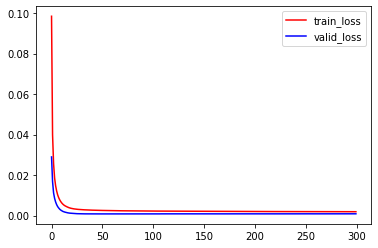

In [0]:
NUM_EPOCHS = 300
best_valid_loss = float('inf')

train_losses = []
train_psnrs = []
valid_losses = []
valid_psnrs = []

for epoch in range(NUM_EPOCHS):
     
    #train the model
    train_loss, train_psnr = train_model(Model, train_loader, optimizer, criterion, epoch)
    
    #evaluate the model
    valid_loss, valid_psnr = evaluate(Model, valid_loader, criterion)
    
    train_losses.append(train_loss)
    train_psnrs.append(train_psnr)
    valid_losses.append(valid_loss)
    valid_psnrs.append(valid_psnr)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Model.state_dict(), '/content/drive/My Drive/Final_Project/good/saved_weights_91_multiple_layers.pt')
    
    # print("Epoch: ", epoch)
    print(f'\n\t Train Loss: {train_loss * 255:.3f} | Train Acc: {train_psnr:.2f} db')
    print(f'\t Val. Loss: {valid_loss * 255:.3f} |  Val. Acc: {valid_psnr:.2f} db\n')


plot_loss(train_losses,'train_loss','red')
plot_loss(valid_losses,'valid_loss',)

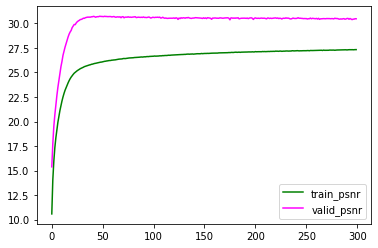

In [0]:
plot_loss(train_psnrs,'train_psnr', 'green')
plot_loss(valid_psnrs, 'valid_psnr', 'magenta')